In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novel-unet-50epoch/novel_unet_from_scratch/novel_unet_latest.keras
/kaggle/input/novel-unet-50epoch/novel_unet_from_scratch/last_epoch.txt
/kaggle/input/novel-unet-50epoch/novel_unet_from_scratch/novel_unet_best.keras
/kaggle/input/novel-unet-50epoch/novel_unet_from_scratch/history.json
/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/

In [2]:
import os, glob, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))

# bật memory growth để đỡ OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except:
            pass

# TỰ ĐỘNG TÌM THƯ MỤC kaggle_3m trong /kaggle/input
ROOT_INPUT = "/kaggle/input"
candidates = glob.glob(os.path.join(ROOT_INPUT, "**", "kaggle_3m"), recursive=True)
if len(candidates) == 0:
    raise FileNotFoundError("Không tìm thấy thư mục 'kaggle_3m'. Hãy Add Data dataset vào notebook trước.")
DATA_DIR = candidates[0]
print("Found DATA_DIR:", DATA_DIR)


2026-01-19 04:39:01.938656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768797542.148261      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768797542.202396      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768797542.682900      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768797542.682940      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768797542.682943      23 computation_placer.cc:177] computation placer alr

TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Found DATA_DIR: /kaggle/input/lgg-mri-segmentation/kaggle_3m


In [3]:
# Quy tắc ghép cặp theo kaggle_3m:
# ảnh: .../TCGA_xxx/xxx.tif
# mask: .../TCGA_xxx/xxx_mask.tif

patient_dirs = sorted([p for p in glob.glob(os.path.join(DATA_DIR, "*")) if os.path.isdir(p)])
print("Num patients:", len(patient_dirs))

pairs = []  # (img_path, mask_path, patient_id)

for pdir in patient_dirs:
    pid = os.path.basename(pdir)
    masks = sorted(glob.glob(os.path.join(pdir, "*_mask.tif")))
    for m in masks:
        img = m.replace("_mask.tif", ".tif")
        if os.path.exists(img):
            pairs.append((img, m, pid))

print("Total (image,mask) pairs:", len(pairs))
print("Example:", pairs[0])


Num patients: 110
Total (image,mask) pairs: 3929
Example: ('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909')


In [4]:
import cv2
import numpy as np
import tensorflow as tf

IMG_SIZE = 256

def _to_py_str(x):
    """
    x có thể là: np.ndarray (0-d), np.bytes_, bytes, hoặc str
    -> trả về str python chuẩn
    """
    # nếu là ndarray (0-d hoặc 1 phần tử) -> lấy item
    if isinstance(x, np.ndarray):
        x = x.item()
    # np.bytes_ hoặc bytes
    if isinstance(x, (np.bytes_, bytes, bytearray)):
        return x.decode("utf-8")
    # đã là str
    return str(x)

def _read_tif_cv2(path_in):
    path = _to_py_str(path_in)

    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # đọc TIFF
    if img is None:
        raise ValueError(f"Cannot read image: {path}")

    img = img.astype(np.float32)

    # đưa về grayscale 1 kênh (H,W,1)
    if img.ndim == 3:
        if img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img[..., 0]
    img = img[..., np.newaxis]
    return img

def read_tif(path):
    img = tf.numpy_function(_read_tif_cv2, [path], Tout=tf.float32)
    img.set_shape([None, None, 1])
    return img

def preprocess(img_path, mask_path):
    img  = read_tif(img_path)      # (H,W,1)
    mask = read_tif(mask_path)     # (H,W,1)

    img  = tf.image.resize(img,  (IMG_SIZE, IMG_SIZE), method="bilinear")
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method="nearest")

    img = img / 255.0
    mask = tf.where(mask > 127.0, 1.0, 0.0)

    img3 = tf.repeat(img, repeats=3, axis=-1)     # (256,256,3)
    return img3, mask

# test nhanh 1 mẫu
img_p, m_p, pid = pairs[0]
x, y = preprocess(tf.constant(img_p), tf.constant(m_p))
print("x:", x.shape, x.dtype, "y:", y.shape, y.dtype)
print("paths:", img_p, m_p)


I0000 00:00:1768797562.864635      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768797562.865283      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


x: (256, 256, 3) <dtype: 'float32'> y: (256, 256, 1) <dtype: 'float32'>
paths: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif


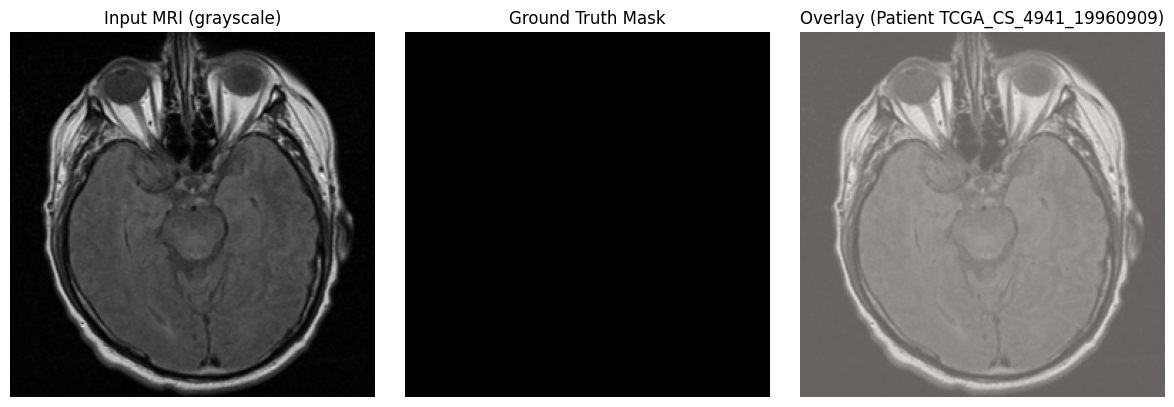

In [5]:
import matplotlib.pyplot as plt

# Lấy 1 mẫu
img_p, m_p, pid = pairs[0]
x, y = preprocess(tf.constant(img_p), tf.constant(m_p))

# convert Tensor -> numpy
x_np = x.numpy()
y_np = y.numpy()

plt.figure(figsize=(12,4))

# Ảnh đầu vào (grayscale – lấy channel 0)
plt.subplot(1,3,1)
plt.title("Input MRI (grayscale)")
plt.imshow(x_np[...,0], cmap="gray")
plt.axis("off")

# Mask ground truth
plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(y_np[...,0], cmap="gray")
plt.axis("off")

# Overlay
plt.subplot(1,3,3)
plt.title(f"Overlay (Patient {pid})")
plt.imshow(x_np[...,0], cmap="gray")
plt.imshow(y_np[...,0], alpha=0.4, cmap="Reds")
plt.axis("off")

plt.tight_layout()
plt.show()



In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

patients = sorted(list(set([pid for _,_,pid in pairs])))
random.shuffle(patients)

n = len(patients)
n_train = int(0.8*n)
n_val   = int(0.1*n)

train_p = set(patients[:n_train])
val_p   = set(patients[n_train:n_train+n_val])
test_p  = set(patients[n_train+n_val:])

train_pairs = [(i,m,p) for (i,m,p) in pairs if p in train_p]
val_pairs   = [(i,m,p) for (i,m,p) in pairs if p in val_p]
test_pairs  = [(i,m,p) for (i,m,p) in pairs if p in test_p]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))
print("Test pairs:", len(test_pairs))



Train pairs: 3133
Val pairs: 409
Test pairs: 387


In [7]:
BATCH_SIZE = 4  # EfficientNetB7 nặng, để nhỏ tránh OOM

def augment(img, mask):
    # lật ngang/dọc, xoay 90 độ (đơn giản, ổn cho MRI slices)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)
    return img, mask

def make_ds(pairs_list, training=False):
    img_paths = [a for a,_,_ in pairs_list]
    msk_paths = [b for _,b,_ in pairs_list]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, msk_paths))
    ds = ds.map(lambda a,b: preprocess(a,b), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_pairs, training=True)
val_ds   = make_ds(val_pairs, training=False)
test_ds  = make_ds(test_pairs, training=False)

# xem 1 batch
xb, yb = next(iter(train_ds))
print(xb.shape, yb.shape)


(4, 256, 256, 3) (4, 256, 256, 1)


In [8]:
import numpy as np
print("x min/max:", float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))
print("y unique:", np.unique(yb.numpy()))


x min/max: 0.0 0.812047004699707
y unique: [0. 1.]


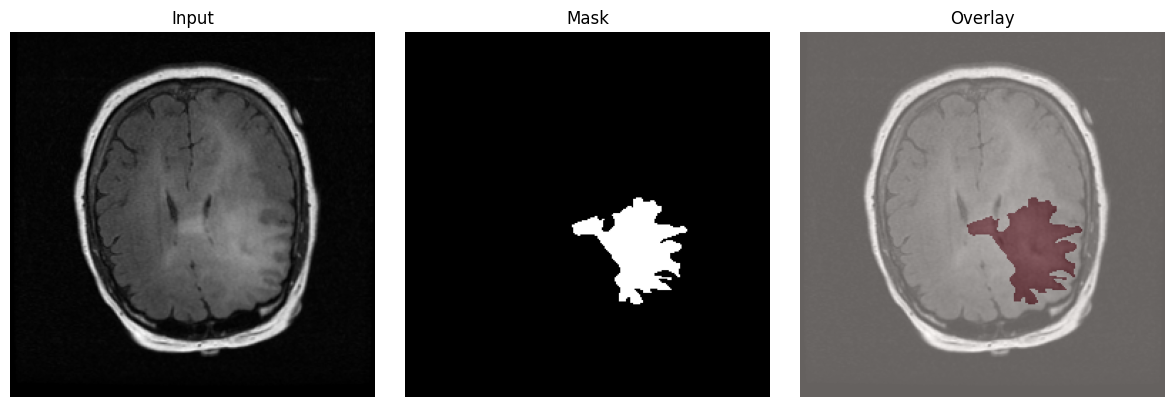

In [9]:
import matplotlib.pyplot as plt

i = 0  # đổi 0..3 để xem mẫu khác
x0 = xb[i].numpy()
y0 = yb[i].numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Input");  plt.imshow(x0[...,0], cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("Mask");   plt.imshow(y0[...,0], cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlay")
plt.imshow(x0[...,0], cmap="gray")
plt.imshow(y0[...,0], alpha=0.4, cmap="Reds")
plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
from tensorflow.keras import layers, Model

BACKBONE = "B7"  # đổi thành "B0" hoặc "B3" nếu bị OOM

def get_backbone(name="B7", input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    if name == "B0":
        base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
        skips = [
            base.get_layer("block2a_expand_activation").output,  # ~128
            base.get_layer("block3a_expand_activation").output,  # ~64
            base.get_layer("block4a_expand_activation").output,  # ~32
            base.get_layer("block6a_expand_activation").output,  # ~16
        ]
        bottleneck = base.output  # ~8
        return base.input, skips, bottleneck
    if name == "B3":
        base = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=input_shape)
        skips = [
            base.get_layer("block2a_expand_activation").output,
            base.get_layer("block3a_expand_activation").output,
            base.get_layer("block4a_expand_activation").output,
            base.get_layer("block6a_expand_activation").output,
        ]
        bottleneck = base.output
        return base.input, skips, bottleneck

    # default B7
    base = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", input_shape=input_shape)
    skips = [
        base.get_layer("block2a_expand_activation").output,
        base.get_layer("block3a_expand_activation").output,
        base.get_layer("block4a_expand_activation").output,
        base.get_layer("block6a_expand_activation").output,
    ]
    bottleneck = base.output
    return base.input, skips, bottleneck

def conv_block(x, filters, name=None):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def up(x):
    return layers.UpSampling2D((2,2), interpolation="bilinear")(x)

def build_unetpp_efficientnet(backbone="B7"):
    inp, [x0_0, x1_0, x2_0, x3_0], x4_0 = get_backbone(backbone)

    f0, f1, f2, f3, f4 = 64, 128, 256, 512, 512

    x0_0 = layers.Conv2D(f0, 1, padding="same")(x0_0)
    x1_0 = layers.Conv2D(f1, 1, padding="same")(x1_0)
    x2_0 = layers.Conv2D(f2, 1, padding="same")(x2_0)
    x3_0 = layers.Conv2D(f3, 1, padding="same")(x3_0)
    x4_0 = layers.Conv2D(f4, 1, padding="same")(x4_0)

    x3_1 = conv_block(layers.Concatenate()([x3_0, up(x4_0)]), f3)
    x2_1 = conv_block(layers.Concatenate()([x2_0, up(x3_0)]), f2)
    x2_2 = conv_block(layers.Concatenate()([x2_0, x2_1, up(x3_1)]), f2)

    x1_1 = conv_block(layers.Concatenate()([x1_0, up(x2_0)]), f1)
    x1_2 = conv_block(layers.Concatenate()([x1_0, x1_1, up(x2_1)]), f1)
    x1_3 = conv_block(layers.Concatenate()([x1_0, x1_1, x1_2, up(x2_2)]), f1)

    x0_1 = conv_block(layers.Concatenate()([x0_0, up(x1_0)]), f0)
    x0_2 = conv_block(layers.Concatenate()([x0_0, x0_1, up(x1_1)]), f0)
    x0_3 = conv_block(layers.Concatenate()([x0_0, x0_1, x0_2, up(x1_2)]), f0)
    x0_4 = conv_block(layers.Concatenate()([x0_0, x0_1, x0_2, x0_3, up(x1_3)]), f0)

    #  thêm 1 upsample để từ 128 -> 256
    x_out = layers.UpSampling2D((2,2), interpolation="bilinear")(x0_4)
    x_out = conv_block(x_out, f0)

    out = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(x_out)
    return Model(inputs=inp, outputs=out, name=f"NovelUNetPP_EfficientNet{backbone}")

model = build_unetpp_efficientnet(BACKBONE)
print("Model output:", model.output_shape)
model.summary()


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model output: (None, 256, 256, 1)


Model: "NovelUNetPP_EfficientNetB7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      2,048 │ block1a_se_excit

 Total params: 81,770,264 (311.93 MB)

 Trainable params: 81,452,625 (310.72 MB)

 Non-trainable params: 317,639 (1.21 MB)

In [11]:
# =====  Loss + Metrics + Compile =====
import tensorflow as tf

EPS = 1e-7

def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0., 1.)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denom = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    return tf.reduce_mean((2. * intersection + EPS) / (denom + EPS))

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0., 1.)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    return tf.reduce_mean((intersection + EPS) / (union + EPS))

# loss tổng hợp: Dice + (1 - IoU)
def combo_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + (1.0 - iou_coef(y_true, y_pred))

# LƯU Ý: cell này giả định bạn đã có biến `model` (đã build xong kiến trúc)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=combo_loss,
    metrics=[dice_coef, iou_coef, "binary_accuracy"]
)


In [12]:
# =============================
# LOAD MODEL + HISTORY FROM KAGGLE DATASET OUTPUT
# (không train nữa)
# =============================
import os, glob, json
import tensorflow as tf

ROOT_INPUT = "/kaggle/input/novel-unet-50epoch/novel_unet_from_scratch"

# Tự tìm file best trong mọi dataset input
best_candidates = glob.glob(os.path.join(ROOT_INPUT, "**", "novel_unet_best.keras"), recursive=True)
latest_candidates = glob.glob(os.path.join(ROOT_INPUT, "**", "novel_unet_latest.keras"), recursive=True)

if len(best_candidates) == 0:
    raise FileNotFoundError("Không tìm thấy novel_unet_best.keras trong /kaggle/input. Hãy kiểm tra bạn đã Add dataset output chưa.")

BEST_PATH = best_candidates[0]
LATEST_PATH = latest_candidates[0] if len(latest_candidates) else None
WORK_DIR_IN = os.path.dirname(BEST_PATH)
HISTORY_JSON = os.path.join(WORK_DIR_IN, "history.json")
EPOCH_TXT = os.path.join(WORK_DIR_IN, "last_epoch.txt")

print("✅ WORK_DIR_IN:", WORK_DIR_IN)
print("✅ BEST_PATH  :", BEST_PATH)
print("✅ LATEST_PATH:", LATEST_PATH)
print("✅ HISTORY_JSON exists?", os.path.exists(HISTORY_JSON))
print("✅ last_epoch exists?", os.path.exists(EPOCH_TXT))

# Load model (đúng custom_objects theo cell 10)
best_model = tf.keras.models.load_model(
    BEST_PATH,
    custom_objects={"combo_loss": combo_loss, "dice_coef": dice_coef, "iou_coef": iou_coef}
)

# Load history dict (để vẽ đồ thị)
history_dict = None
if os.path.exists(HISTORY_JSON):
    with open(HISTORY_JSON, "r") as f:
        history_dict = json.load(f)
    print("✅ Loaded history keys:", list(history_dict.keys()))
else:
    print("⚠️ Không có history.json -> sẽ không vẽ được curve theo epoch.")


✅ WORK_DIR_IN: /kaggle/input/novel-unet-50epoch/novel_unet_from_scratch
✅ BEST_PATH  : /kaggle/input/novel-unet-50epoch/novel_unet_from_scratch/novel_unet_best.keras
✅ LATEST_PATH: /kaggle/input/novel-unet-50epoch/novel_unet_from_scratch/novel_unet_latest.keras
✅ HISTORY_JSON exists? True
✅ last_epoch exists? True
✅ Loaded history keys: ['binary_accuracy', 'dice_coef', 'iou_coef', 'loss', 'val_binary_accuracy', 'val_dice_coef', 'val_iou_coef', 'val_loss', 'learning_rate']


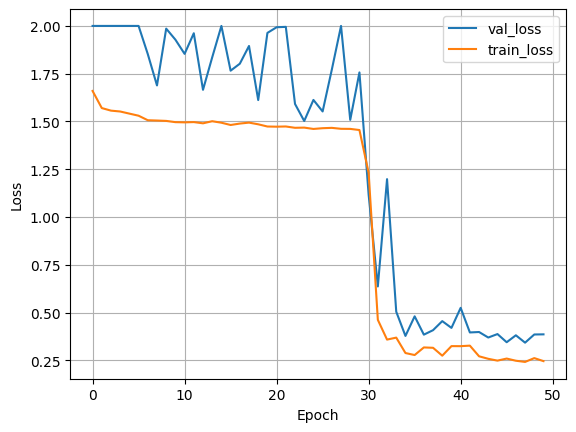

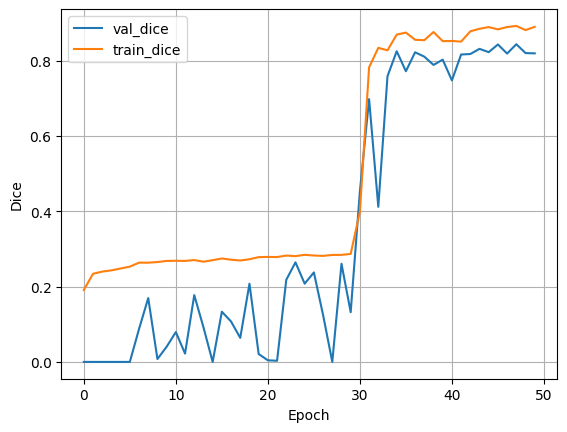

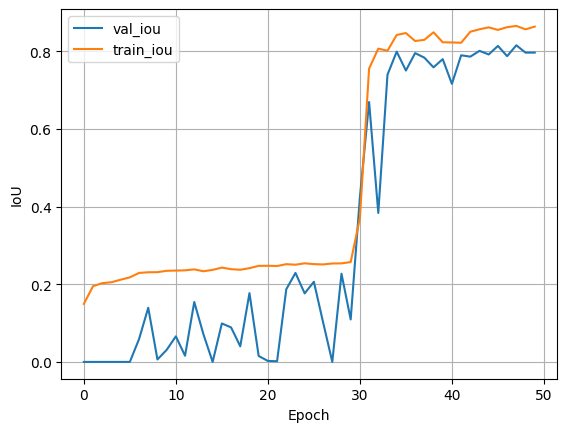

In [13]:
def plot_history_any(hist_or_dict):
    # hist_or_dict: Keras History hoặc dict từ history.json
    if hist_or_dict is None:
        print("Không có history để vẽ.")
        return

    if isinstance(hist_or_dict, dict):
        h = hist_or_dict
    else:
        h = hist_or_dict.history

    import matplotlib.pyplot as plt

    if "loss" in h:
        plt.figure()
        if "val_loss" in h: plt.plot(h["val_loss"], label="val_loss")
        plt.plot(h["loss"], label="train_loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

    if "dice_coef" in h:
        plt.figure()
        if "val_dice_coef" in h: plt.plot(h["val_dice_coef"], label="val_dice")
        plt.plot(h["dice_coef"], label="train_dice")
        plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.legend(); plt.grid(True); plt.show()

    if "iou_coef" in h:
        plt.figure()
        if "val_iou_coef" in h: plt.plot(h["val_iou_coef"], label="val_iou")
        plt.plot(h["iou_coef"], label="train_iou")
        plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.legend(); plt.grid(True); plt.show()

plot_history_any(history_dict)


I0000 00:00:1768797610.086756      67 service.cc:152] XLA service 0x787cb003c680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768797610.086796      67 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768797610.086799      67 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768797613.238709      67 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-19 04:40:18.002705: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 04:40:18.160497: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 04:40:19.562495: E external/local_xl

96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - binary_accuracy: 0.9974 - dice_coef: 0.8992 - iou_coef: 0.8694 - loss: 0.2313

2026-01-19 04:41:02.579715: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 04:41:02.732641: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 04:41:03.874926: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 04:41:04.016838: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-19 04:41:04.802905: E external/local_xla/xla/stream_

97/97 ━━━━━━━━━━━━━━━━━━━━ 91s 447ms/step - binary_accuracy: 0.9974 - dice_coef: 0.8988 - iou_coef: 0.8689 - loss: 0.2323
Test metrics: {'loss': 0.27888667583465576, 'compile_metrics': 0.8771445155143738}


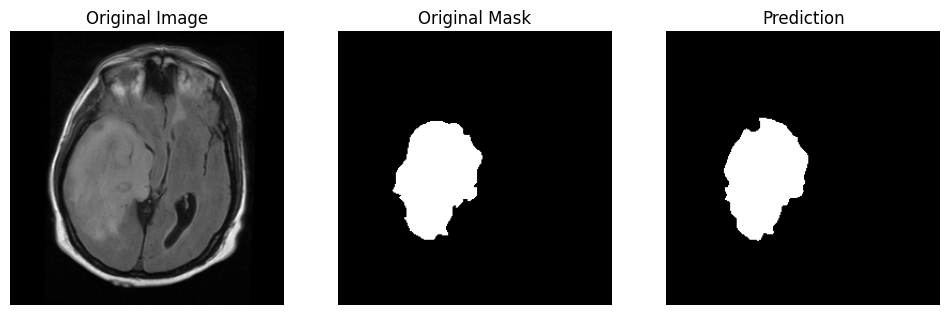

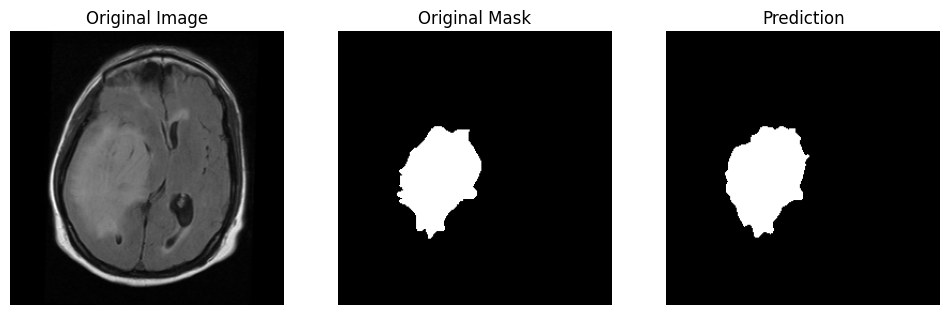

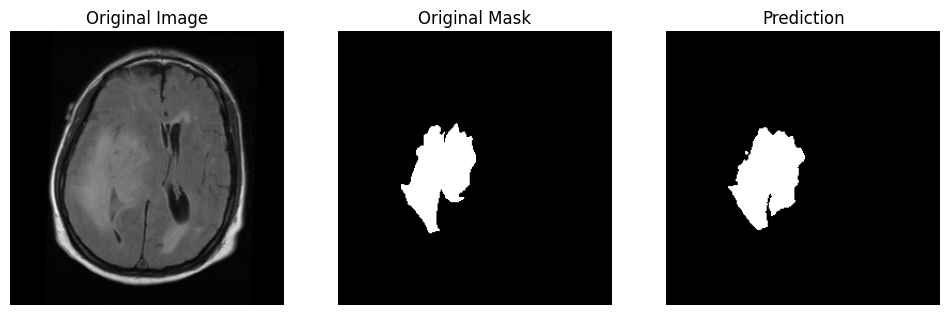

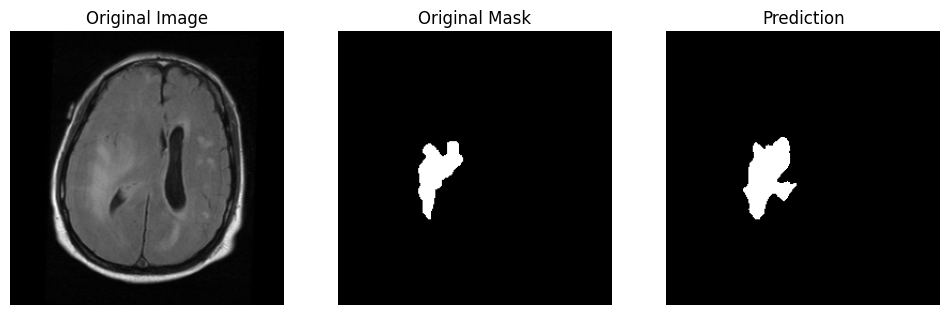

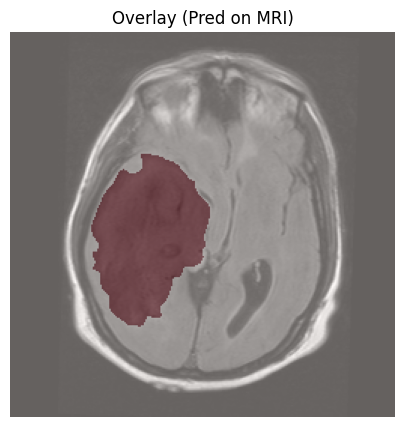

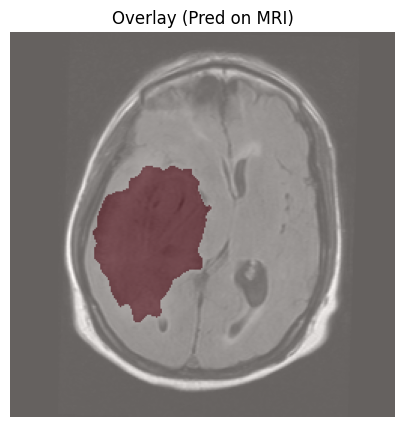

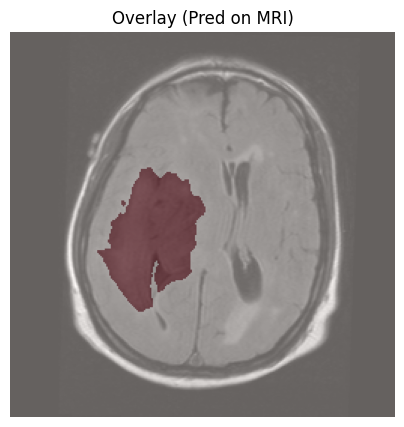

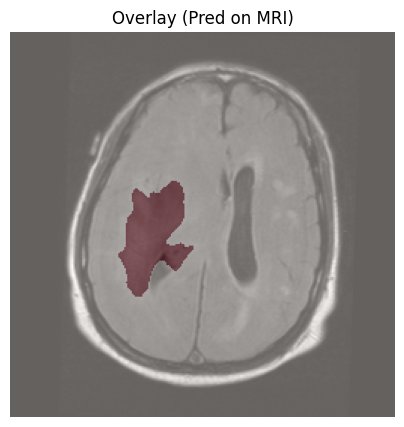

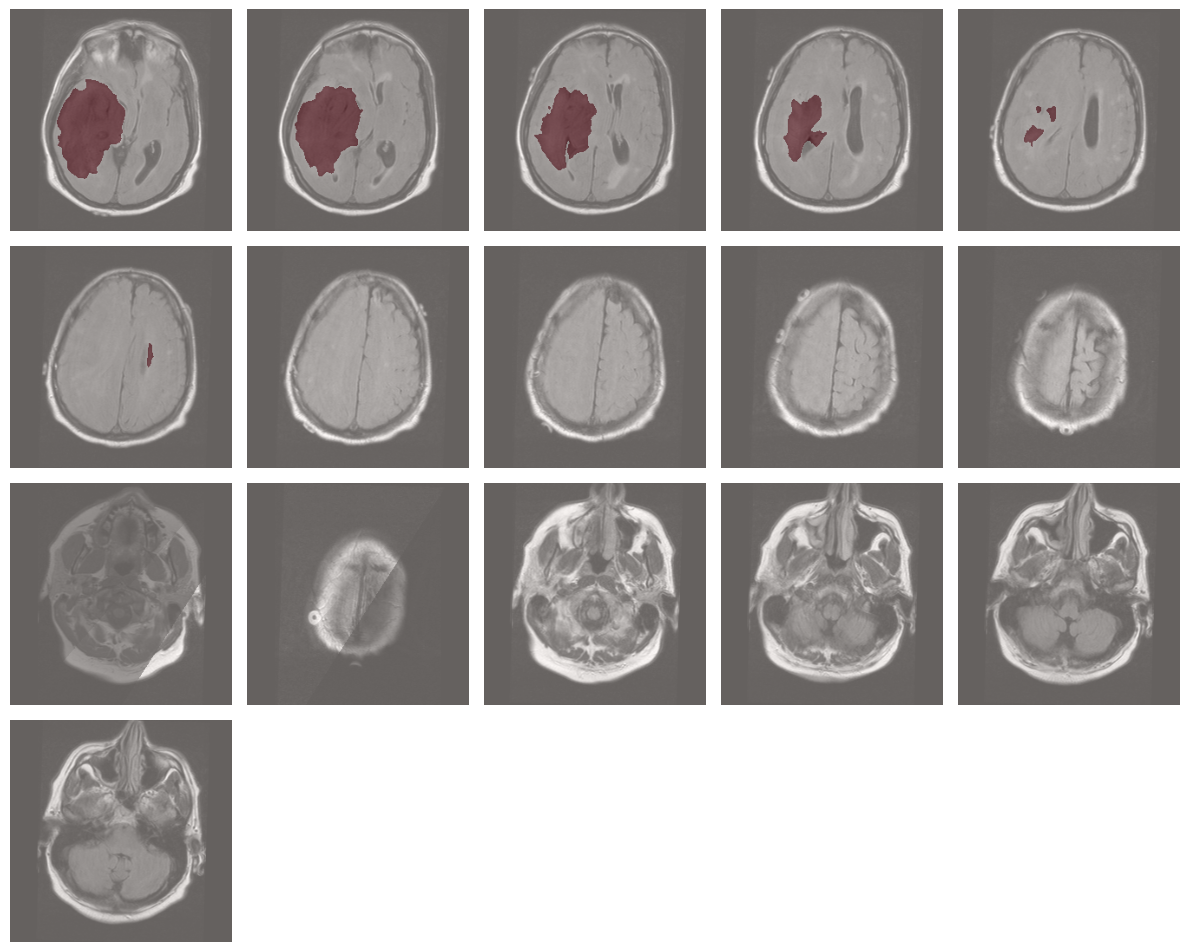

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Evaluate on test set
test_metrics = best_model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(best_model.metrics_names, test_metrics)))

THRESH = 0.5  # đúng theo bài báo

# 2) 3-panel visualization (Image / Mask / Prediction) giống Fig. 9
def show_predictions_3panel(ds, n=4):
    for xb, yb in ds.take(1):
        pred = best_model.predict(xb, verbose=0)
        pred_bin = (pred > THRESH).astype(np.float32)

        for i in range(min(n, xb.shape[0])):
            img = xb[i].numpy()
            gt = yb[i].numpy().squeeze()
            pr = pred_bin[i].squeeze()

            gray = img[...,0]  # vì bạn lặp grayscale thành 3 kênh

            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1); plt.title("Original Image"); plt.imshow(gray, cmap="gray"); plt.axis("off")
            plt.subplot(1,3,2); plt.title("Original Mask");  plt.imshow(gt, cmap="gray");   plt.axis("off")
            plt.subplot(1,3,3); plt.title("Prediction");     plt.imshow(pr, cmap="gray");   plt.axis("off")
            plt.show()

show_predictions_3panel(test_ds, n=4)

# 3) Overlay visualization (alpha=0.4) giống cách họ mô tả
def show_overlay(ds, n=6, alpha=0.4):
    for xb, yb in ds.take(1):
        pred = best_model.predict(xb, verbose=0)
        pr = (pred > THRESH).astype(np.float32)

        for i in range(min(n, xb.shape[0])):
            gray = xb[i].numpy()[...,0]
            plt.figure(figsize=(5,5))
            plt.title("Overlay (Pred on MRI)")
            plt.imshow(gray, cmap="gray")
            plt.imshow(pr[i].squeeze(), alpha=alpha, cmap="Reds")
            plt.axis("off")
            plt.show()

show_overlay(test_ds, n=6, alpha=0.4)

# 4) 5x5 grid overlay (25 samples) giống Fig. 4 (paper)
def grid_5x5_overlay(ds, alpha=0.4):
    imgs = []
    for xb, yb in ds.take(4):  # 4 batches x batch_size=... đủ >=25 là được
        pred = best_model.predict(xb, verbose=0)
        pr = (pred > THRESH).astype(np.float32)
        for i in range(xb.shape[0]):
            imgs.append((xb[i].numpy()[...,0], pr[i].squeeze()))
    imgs = imgs[:25]

    plt.figure(figsize=(12,12))
    for k, (gray, maskp) in enumerate(imgs):
        plt.subplot(5,5,k+1)
        plt.imshow(gray, cmap="gray")
        plt.imshow(maskp, alpha=alpha, cmap="Reds")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

grid_5x5_overlay(test_ds, alpha=0.4)
